<a href="https://colab.research.google.com/github/rashmigpai/IntroToBigData/blob/main/Final_Project_Rashmi_Pai_DecisionTree_And_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Final Project Presentation
---
### Logistic Regression

### Decision Tree

In [ ]:
!pip install pyspark

In [ ]:
!apt-get update 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark
import findspark
findspark.init()

### STEP 1 Decision Tree Set up 
---

Work on your project data to start preliminary analysis:

Q3.Prepare data by using the following preprocessing transformation and tasks if required:

a)Please standardize the data.

b)Check for null values.

c)Check for outliers.

d)Conduct Feature selection or Feature Engineering.

#### Goal
---

The dataset comes from the UCI Machine Learning repository, and it is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. 

The classification goal is to predict whether the client will subscribe (1/0) to a term deposit (variable y).

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *

spark = SparkSession \
.builder \
.master("local") \
.appName("Bank Data") \
.config("spark.sql.shuffle.partitions","1") \
.getOrCreate()

In [131]:
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [132]:
df.show(20, truncate=False)

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job        |marital |education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|59 |admin.     |married |secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1       |-1   |0       |unknown |yes    |
|56 |admin.     |married |secondary|no     |45     |no     |no  |unknown|5  |may  |1467    |1       |-1   |0       |unknown |yes    |
|41 |technician |married |secondary|no     |1270   |yes    |no  |unknown|5  |may  |1389    |1       |-1   |0       |unknown |yes    |
|55 |services   |married |secondary|no     |2476   |yes    |no  |unknown|5  |may  |579     |1       |-1   |0       |unknown |yes    |
|54 |admin.     |married |tertiary |no     |184    |no     |no

#### Summay of data
---

**Categorical Variables :**

[1] job : admin,technician, services, management, retired, blue-collar, unemployed, entrepreneur, housemaid, unknown, self-employed, student

[2] marital : married, single, divorced

[3] education: secondary, tertiary, primary, unknown

[4] default : yes, no

[5] housing : yes, no

[6] loan : yes, no

[7] deposit : yes, no **(Dependent Variable)**

[8] contact : unknown, cellular, telephone

[9] month : jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec

[10] poutcome: unknown, other, failure, success

**Numerical Variables:**
[1] age

[2] balance

[3] day

[4] duration

[5] campaign

[6] pdays

[7] previous

In [133]:
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
df.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|  count|             11162|  11162|   11162|    11162|  11162|             11162|  11162|11162|   11162|             11162|11162|             11162|             11162|             11162|             11162|   11162|  11162|
|   mean|41.231947679627304|   null|    null|     null|   null|1528.5385235620856|   null| null|    null

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np

plt.style.use('fivethirtyeight')

**d) Conduct Feature selection or Feature Engineering.**

---

In [136]:
df.groupby("deposit").count().toPandas()

,deposit,count
0,yes,5289
1,no,5873


In [139]:
df.groupby("job").count().toPandas()

,job,count
0,admin.,1334
1,technician,1823
2,services,923
3,management,2566
4,retired,778
5,blue-collar,1944
6,unemployed,357
7,entrepreneur,328
8,housemaid,274
9,unknown,70


**Find count of jobs who have a deposit.**

In [140]:
df.filter(df.deposit=='yes').groupby("job").count().toPandas()

,job,count
0,admin.,631
1,technician,840
2,services,369
3,management,1301
4,retired,516
5,blue-collar,708
6,unemployed,202
7,entrepreneur,123
8,housemaid,109
9,unknown,34


Combine similar job categories

In [142]:
from pyspark.sql.functions import when
df_new = df.withColumn("job",\
                       when((df["job"]=="management")|\
                            (df["job"]=="admin."),"white-collar")\
                       .when((df["job"]=='services')|\
                             (df["job"]=='housemaid'),"pink-collar")\
                       .when((df["job"]=='retired')|\
                             (df["job"]=='student')|\
                             (df["job"]=='unemployed')|\
                             (df["job"]=='unknown'), "other")\
                       .otherwise(df["job"]))

In [143]:
df_new.groupby("job").count().toPandas()

,job,count
0,white-collar,3900
1,technician,1823
2,pink-collar,1197
3,other,1565
4,blue-collar,1944
5,entrepreneur,328
6,self-employed,405


In [144]:
df_new.filter(df.deposit=='yes').groupby("job").count().toPandas()

,job,count
0,white-collar,1932
1,technician,840
2,pink-collar,478
3,other,1021
4,blue-collar,708
5,entrepreneur,123
6,self-employed,187


In [145]:
df=df_new

**c) checking for outliers**

---

In [146]:
df.groupby("poutcome").count().toPandas()

,poutcome,count
0,unknown,8326
1,other,537
2,failure,1228
3,success,1071


**Combine unknown and other since we don't know if its success/failure.**

In [147]:
df_new = df.withColumn("poutcome",\
                       when((df["poutcome"]=="other"),"unknown")
                       .otherwise(df["poutcome"]))

In [148]:
df_new.groupby("poutcome").count().toPandas()

,poutcome,count
0,unknown,8863
1,failure,1228
2,success,1071


In [160]:
df=df_new

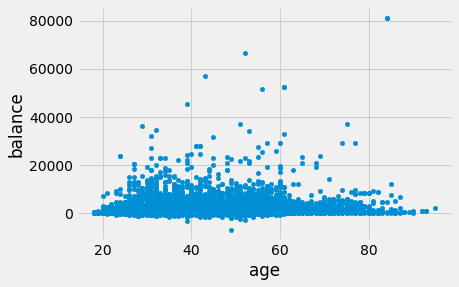

In [150]:
df.toPandas().plot(kind='scatter', x='age', y='balance');

Across all ages, majority of people have savings of less than 20000.

In [151]:
df.show(truncate=False)

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job         |marital |education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|59 |white-collar|married |secondary|no     |2343   |yes    |no  |unknown|5  |may  |1042    |1       |-1   |0       |unknown |yes    |
|56 |white-collar|married |secondary|no     |45     |no     |no  |unknown|5  |may  |1467    |1       |-1   |0       |unknown |yes    |
|41 |technician  |married |secondary|no     |1270   |yes    |no  |unknown|5  |may  |1389    |1       |-1   |0       |unknown |yes    |
|55 |pink-collar |married |secondary|no     |2476   |yes    |no  |unknown|5  |may  |579     |1       |-1   |0       |unknown |yes    |
|54 |white-collar|married |tertiary |no     |184    |no

**Summarizing numerical values**

In [153]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


**b) Checking for null values.**

---

In [154]:
df.createOrReplaceTempView("DATA")
for column in df.columns:
  print(f"printing rows where {column} is null")
  spark.sql(f"SELECT * FROM DATA where {column} IS NULL").show()

printing rows where age is null
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+

printing rows where job is null
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
+---+---+-------+---------+-------+-------+-------+----+----

**Feature selection and Feature engineering is now compelted.**


**For numerical values, plot a pairplot**

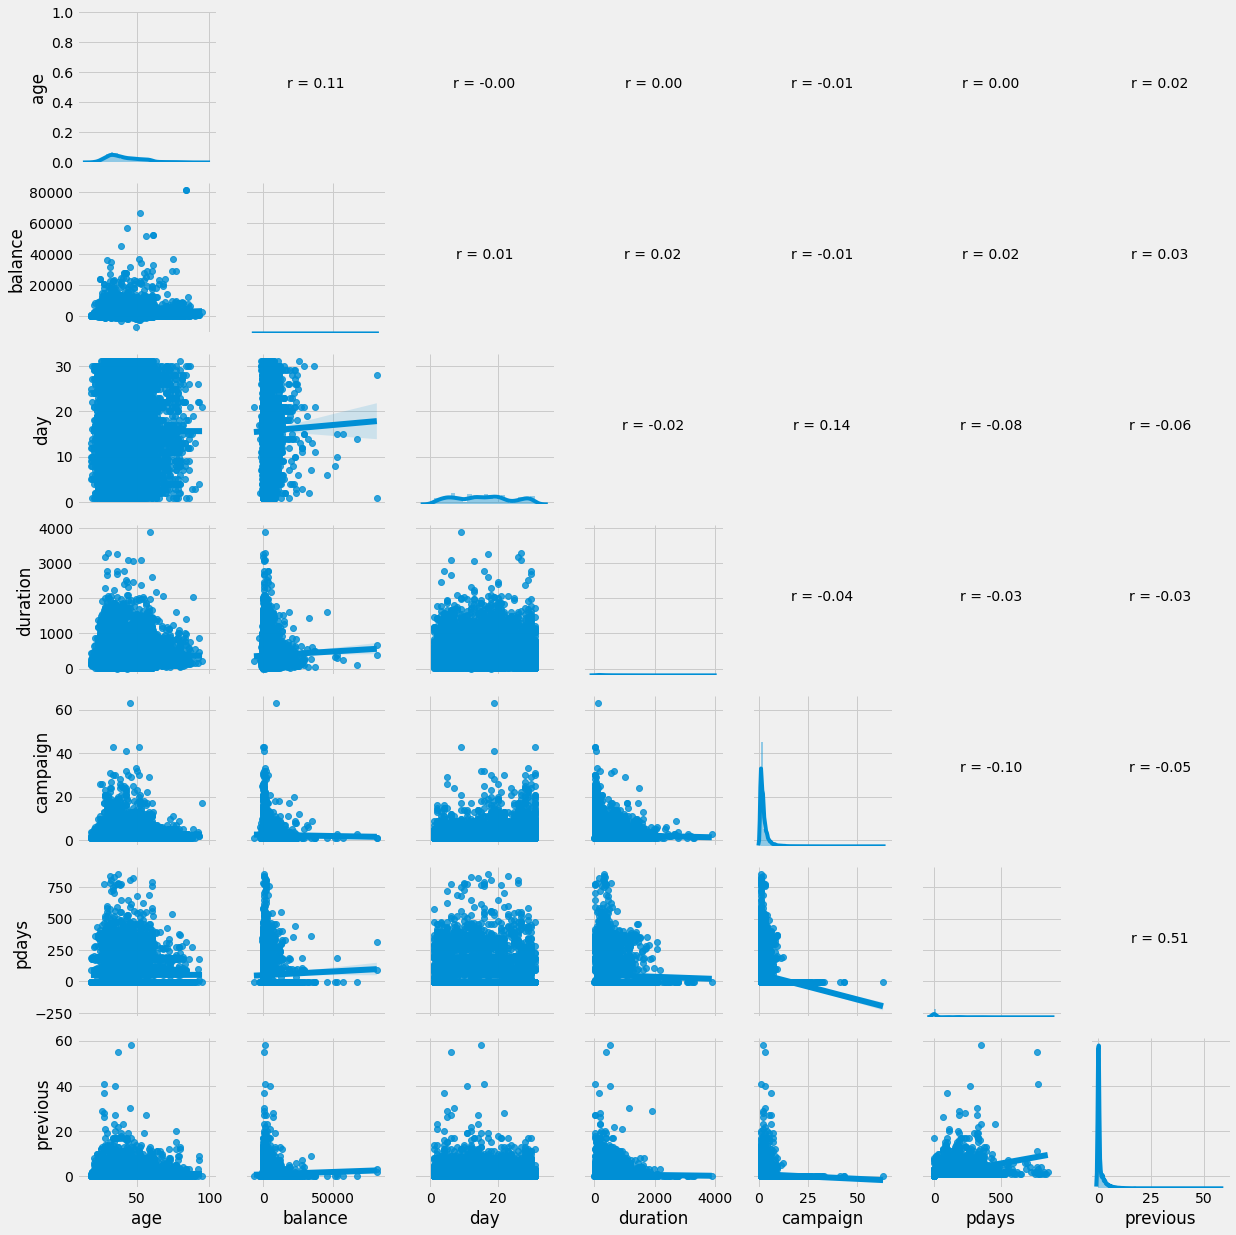

In [155]:
numeric_data = df.select(numeric_features).toPandas()
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(numeric_data)
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)


It’s obvious that there aren’t highly correlated numeric variables. Therefore, we will keep all of them for the model. However, day and month columns are not really useful, we will remove these two columns.

In [156]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 
               'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 
               'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



#### Preparing Data for Machine Learning
---
The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [161]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

The above code: 

* indexes each categorical column using the StringIndexer
* converts the indexed categories into one-hot encoded variables. 
* resulting output has the binary vectors appended to the end of each row. 
* We use the StringIndexer again to encode our labels to label indices. 
* Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

##### Pipeline
----
We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. 

A Pipeline’s stages are specified as an ordered array.

In [162]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()


root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [163]:
df.show(truncate=False)

+-----+------------------------------------------------------------------------------------------------------+---+------------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|label|features                                                                                              |age|job         |marital |education|default|balance|housing|loan|contact|duration|campaign|pdays|previous|poutcome|deposit|
+-----+------------------------------------------------------------------------------------------------------+---+------------+--------+---------+-------+-------+-------+----+-------+--------+--------+-----+--------+--------+-------+
|1.0  |(24,[0,6,8,11,13,15,16,18,19,20,21,22],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0,2343.0,1042.0,1.0,-1.0])     |59 |white-collar|married |secondary|no     |2343   |yes    |no  |unknown|1042    |1       |-1   |0       |unknown |yes    |
|1.0  |(24,[0,6,8,11,12,13,15,16,18,19,20,21,22],[1.0,1.0,1.0,1.

**Randomly split data into train and test sets, and set seed for reproducibility.**


In [164]:
import numpy as np
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [165]:
train, test = df.randomSplit([0.7, 0.3], seed = rnd_seed)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7836
Test Dataset Count: 3326


### Step 2 Implement Logistics Regression.

Conduct  Logistic Regression and answer the following questions:

Q4 Implement Logistic Regression.

a)Objective and rationale of using the specific algorithm to achieve the objective.

a)Steps of implementing the algorithm with regards to the context. Create relevant graphs.

b)Interpretation of the results and prediction accuracy achieved.

c)Performance improvement techniques and improved accuracy achieved. Use feature selection, variable importance, compare RMSE(Regression) across models and Information gain (Decision Trees). K-fold cross validation , grid search etc.

### Logistic Regression Model
---

In [166]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

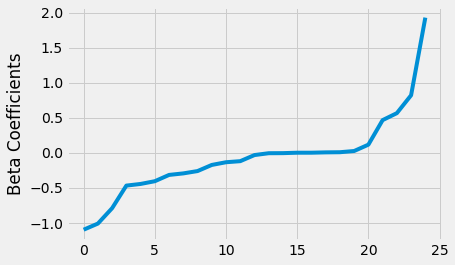

In [96]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()


Summarize the model over the training set, we can also obtain the receiver-operating characteristic and areaUnderROC.

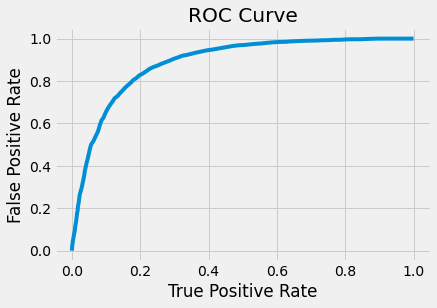

Training set areaUnderROC: 0.8878150327957891


In [167]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

**Precision/Recall Summary**


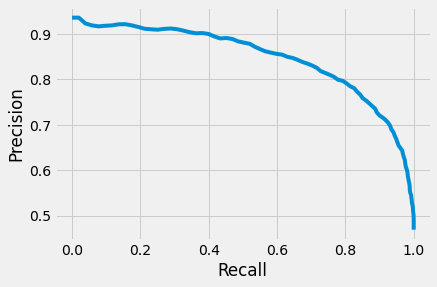

In [98]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


Make predictions on the test set.

In [168]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------------+-----+--------------------+----------+--------------------+
|age|         job|label|       rawPrediction|prediction|         probability|
+---+------------+-----+--------------------+----------+--------------------+
| 26|white-collar|  0.0|[1.06229815725466...|       0.0|[0.74312948113415...|
| 31|white-collar|  0.0|[0.67499136056654...|       0.0|[0.66261990578626...|
| 32|white-collar|  0.0|[-0.8261289017524...|       1.0|[0.30446421516128...|
| 33|white-collar|  0.0|[1.81734674731004...|       0.0|[0.86024745308123...|
| 34|white-collar|  0.0|[1.18288308430367...|       0.0|[0.76546579395991...|
| 34|white-collar|  0.0|[0.06940799992559...|       0.0|[0.51734503727337...|
| 37|white-collar|  0.0|[1.38628380764227...|       0.0|[0.79999831143823...|
| 41|white-collar|  0.0|[0.39557377785052...|       0.0|[0.59762374968451...|
| 42|white-collar|  0.0|[-0.0454254915025...|       1.0|[0.48864557952104...|
| 43|white-collar|  0.0|[0.94785700219467...|       0.0|[0.72068

**Evaluate our Logistic Regression model.**



In [169]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8777086020970232


### Q4 Implement Decision Trees
---

a)Objective and rationale of using the specific algorithm to achieve the objective.

a)Steps of implementing the algorithm with regards to the context. Create relevant graphs.

b)Interpretation of the results and prediction accuracy achieved.

c)Performance improvement techniques and improved accuracy achieved. Use feature selection, variable importance, compare RMSE(Regression) across models and Information gain (Decision Trees). K-fold cross validation , grid searchetc.

### Decision Tree Classifier
---

Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multi-class classification, do not require feature scaling, and are able to capture non-linearities and feature interactions.


In [170]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------------+-----+--------------+----------+--------------------+
|age|         job|label| rawPrediction|prediction|         probability|
+---+------------+-----+--------------+----------+--------------------+
| 26|white-collar|  0.0|[2946.0,841.0]|       0.0|[0.77792447847900...|
| 31|white-collar|  0.0|[2946.0,841.0]|       0.0|[0.77792447847900...|
| 32|white-collar|  0.0|[2946.0,841.0]|       0.0|[0.77792447847900...|
| 33|white-collar|  0.0|[2946.0,841.0]|       0.0|[0.77792447847900...|
| 34|white-collar|  0.0|[2946.0,841.0]|       0.0|[0.77792447847900...|
| 34|white-collar|  0.0|[2946.0,841.0]|       0.0|[0.77792447847900...|
| 37|white-collar|  0.0|[2946.0,841.0]|       0.0|[0.77792447847900...|
| 41|white-collar|  0.0|[2946.0,841.0]|       0.0|[0.77792447847900...|
| 42|white-collar|  0.0|[2946.0,841.0]|       0.0|[0.77792447847900...|
| 43|white-collar|  0.0|[2946.0,841.0]|       0.0|[0.77792447847900...|
+---+------------+-----+--------------+----------+--------------

**Evaluate our Decision Tree model.**

In [171]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.5136194389758237


One simple decision tree performed poorly because it is too weak given the range of different features. 

The prediction accuracy of decision trees can be improved by `Ensemble` methods, such as `Random Forest` and `Gradient-Boosted Tree`.

### Random Forest Classifier
---

In [172]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------------+-----+--------------------+----------+--------------------+
|age|         job|label|       rawPrediction|prediction|         probability|
+---+------------+-----+--------------------+----------+--------------------+
| 26|white-collar|  0.0|[12.4556976674967...|       0.0|[0.62278488337483...|
| 31|white-collar|  0.0|[12.9129261577821...|       0.0|[0.64564630788910...|
| 32|white-collar|  0.0|[9.04176861728067...|       1.0|[0.45208843086403...|
| 33|white-collar|  0.0|[14.3824726129744...|       0.0|[0.71912363064872...|
| 34|white-collar|  0.0|[13.3038161193021...|       0.0|[0.66519080596510...|
| 34|white-collar|  0.0|[9.81560819300858...|       1.0|[0.49078040965042...|
| 37|white-collar|  0.0|[13.6835588535638...|       0.0|[0.68417794267819...|
| 41|white-collar|  0.0|[12.5762362789825...|       0.0|[0.62881181394912...|
| 42|white-collar|  0.0|[9.17832343785396...|       1.0|[0.45891617189269...|
| 43|white-collar|  0.0|[12.0591449744531...|       0.0|[0.60295

**Evaluate our Random Forest Classifier.**

In [173]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8666415023325458


### Gradient-Boosted Tree Classifier
---

In [174]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)


+---+------------+-----+--------------------+----------+--------------------+
|age|         job|label|       rawPrediction|prediction|         probability|
+---+------------+-----+--------------------+----------+--------------------+
| 26|white-collar|  0.0|[0.59770480532727...|       0.0|[0.76770717237505...|
| 31|white-collar|  0.0|[0.15562447058564...|       0.0|[0.57719008419443...|
| 32|white-collar|  0.0|[-0.1875944105105...|       1.0|[0.40728781701312...|
| 33|white-collar|  0.0|[1.16858907984804...|       0.0|[0.91190966886438...|
| 34|white-collar|  0.0|[1.04056234220111...|       0.0|[0.88905501642823...|
| 34|white-collar|  0.0|[0.03089720844761...|       0.0|[0.51544369016133...|
| 37|white-collar|  0.0|[1.19446270639332...|       0.0|[0.91597890316225...|
| 41|white-collar|  0.0|[0.19579109789658...|       0.0|[0.59666352263001...|
| 42|white-collar|  0.0|[-0.1222016962436...|       1.0|[0.43920149088407...|
| 43|white-collar|  0.0|[0.23079422999185...|       0.0|[0.61339

**Evaluate our Gradient-Boosted Tree Classifier.**

In [175]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8811277666387048


`Gradient-Boosted Tree` achieved the best results, we will try tuning this model with the `ParamGridBuilder` and the `CrossValidator`. 

Before that we can use `explainParams()` to print a list of all params and their definitions to understand what params available for tuning.

In [107]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [176]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)


0.887843119873661